In [1]:
%autosave 0

import numpy as np
import pandas as pd
from datetime import date, timedelta

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D

from joblib import dump

Autosave disabled


In [2]:
data = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")

In [3]:
data.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
0,ABW,North America,Aruba,2020-03-13,2.0,2.0,NaN,0.0,0.0,NaN,...,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29
1,ABW,North America,Aruba,2020-03-19,NaN,NaN,0.286,NaN,NaN,0.0,...,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29
2,ABW,North America,Aruba,2020-03-20,4.0,2.0,0.286,0.0,0.0,0.0,...,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29


In [4]:
df_temp = data[data["date"].isin([f"{date.today()}"])] ## keep only row of today situation
i = df_temp[df_temp.location == 'World'].index ## find index of world row & drop them, i dont need it here
df_temp = df_temp.drop(i)

In [5]:
def plotSituation(subject,df=df_temp):
    """ show the days situation in the world for all features """
    plt.figure(figsize=(20,5))
    plt.xticks(rotation=90)
    plt.scatter(df["location"],df[f"{subject}"])
    plt.title(f"World {subject} situation")
    plt.legend
    plt.show()

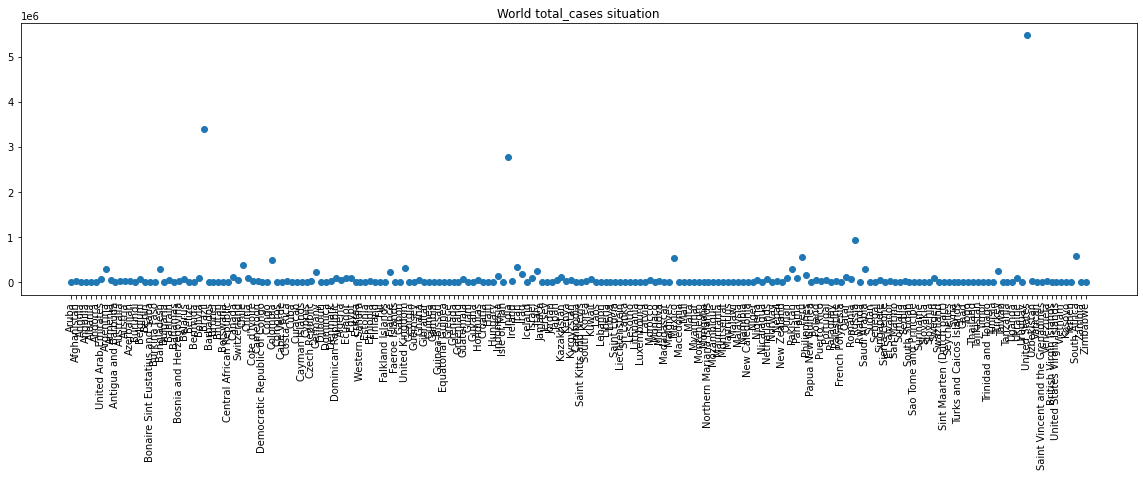

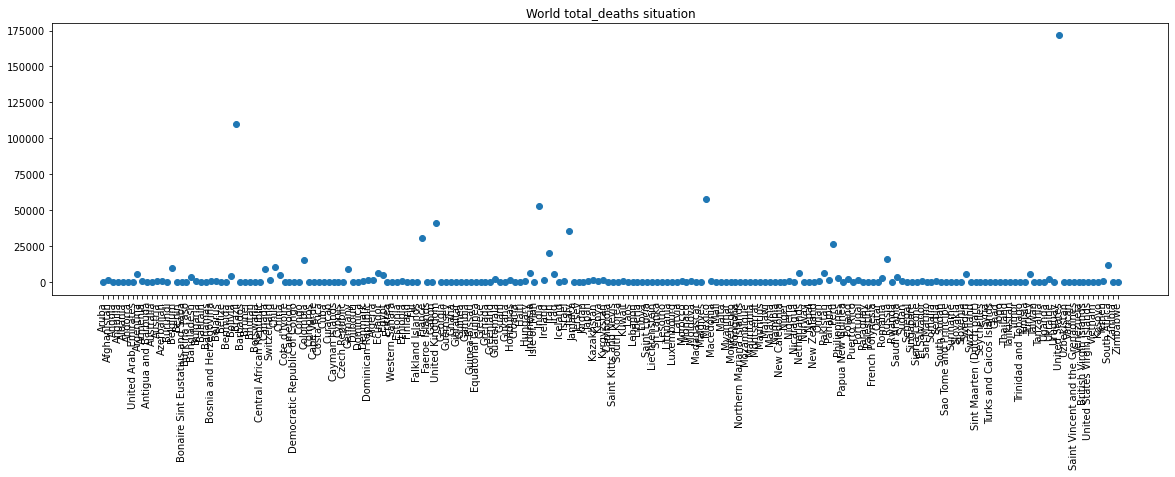

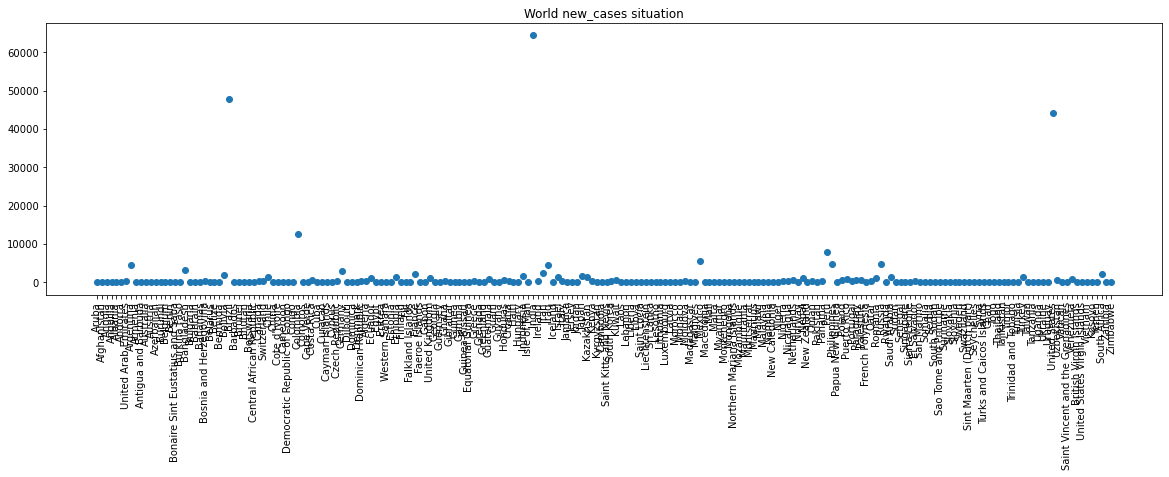

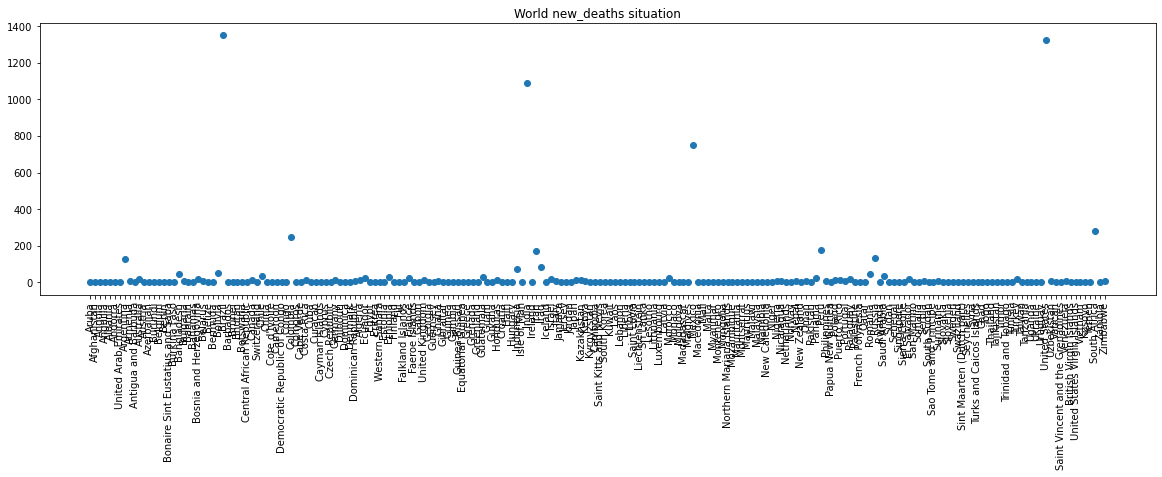

In [6]:
plotSituation("total_cases")
plotSituation("total_deaths")
plotSituation("new_cases")
plotSituation("new_deaths")

We can't read country but, this not the goal here, we will do this at the end with the clustering

In [7]:
## keep location in var before drop it
location = df_temp["location"].values

In [8]:
df = pd.DataFrame(df_temp, columns=["total_cases","new_cases","total_deaths","new_deaths"])

In [9]:
X = df.values

In [10]:
## init var of script
s_color = "#B32A4E"
seed = 69 
_k = 4

In [11]:
model = KMeans(n_clusters=_k, init='k-means++', max_iter=300, random_state=seed)
model.fit(X)

KMeans(n_clusters=4, random_state=69)

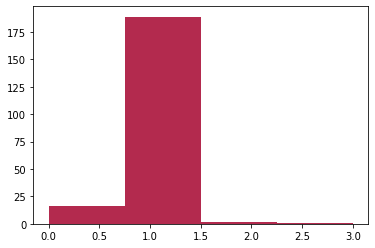

In [12]:
plt.hist(model.labels_, color=s_color, bins=_k)
plt.show()

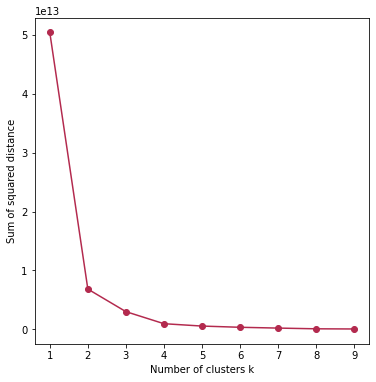

In [13]:
def bestk(): 
    """Run the Kmeans algorithm and get the index of data points clusters"""
    # never do that out of function and do not return any model from this ope
    sse = []
    list_k = list(range(1, 10))


    for k in list_k:
        ## must re create model, because K is not the _k choosen before and change at each iter
        model = KMeans(n_clusters=k, init='k-means++', max_iter=300,random_state=seed)
        model.fit(X)
        sse.append(model.inertia_)

    # Plot sse against k
    plt.figure(figsize=(6, 6))
    plt.plot(list_k, sse, '-o', color=s_color)
    plt.xlabel(r'Number of clusters k')
    plt.ylabel('Sum of squared distance');
    
bestk()    

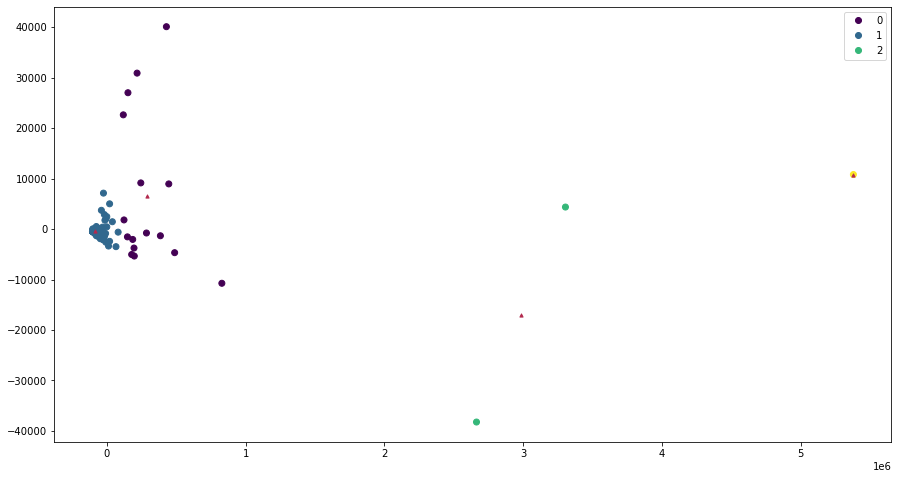

In [14]:
# reduce the features 
pca = PCA(n_components=2, random_state=seed)
reduced_features = pca.fit_transform(X)

# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(model.cluster_centers_)

targets = ['0', '1', '2'] ## a way to factorize this ?? 

plt.figure(figsize=(15,8))
# plot the data
scatter = plt.scatter(reduced_features[:,0], reduced_features[:,1], c=model.predict(X))
# plot the center of cluster
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker="^", s=10, c=s_color)
# plot the legend
plt.legend(handles=scatter.legend_elements()[0], labels=targets)

-- Details Explained variance ratio --
0.9998533235710825
0.00011919911909803278


Text(0, 0.5, 'variance %')

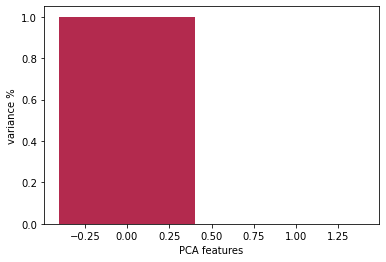

In [15]:
print("-- Details Explained variance ratio --")
for i in pca.explained_variance_ratio_:
    print(i)
    
# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color=s_color)
plt.xlabel('PCA features')
plt.ylabel('variance %')

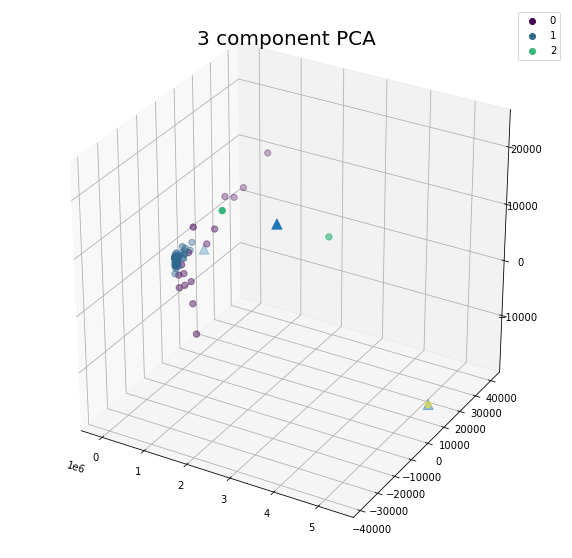

-- Details Explained variance ratio --
0.9998533235710825
0.00011919911909803278
2.747026019153483e-05


Text(0, 0.5, 'variance %')

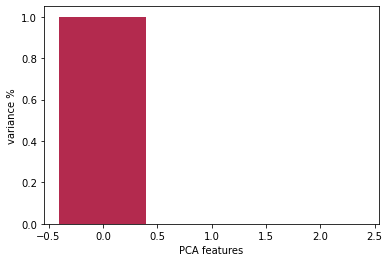

In [16]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('3 component PCA', fontsize=20)

pca = PCA(n_components=3, random_state=seed)
reduced_features = pca.fit_transform(X)

# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(model.cluster_centers_)

d=model.predict(X)
f = reduced_cluster_centers[:, 0]
g = reduced_cluster_centers[:, 1]
h = reduced_cluster_centers[:,2]

x = reduced_features[:, 0]
y = reduced_features[:, 1]
z = reduced_features[:, 2]

targets = ['0', '1', '2'] ## a way to factorize this ?? 

scatter = ax.scatter(x,y,z, s=40, c=d)
ax.scatter(f,g,h, marker="^", s=100, cmap=s_color)
ax.legend(handles=scatter.legend_elements()[0], labels=targets)
ax.grid()
plt.show()

print("-- Details Explained variance ratio --")
for i in pca.explained_variance_ratio_:
    print(i)
    
# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color=s_color)
plt.xlabel('PCA features')
plt.ylabel('variance %')

In [17]:
# Creating an empty dictionary 
_3dClusterList = {} 
  
# Adding list's as value 
_3dClusterList["clusterSet"] = location
_3dClusterList["clusterX"] = x
_3dClusterList["clusterY"] = y
_3dClusterList["clusterZ"] = z

## I dump the data for each location with the 3 axes x,y,z for the real 3d volume on the app
# dump(_3dClusterList, "endPoint/_3dClusterList.joblib")

In [18]:
# print(_3dClusterList["clusterSet"][140])
# print(_3dClusterList["clusterX"][140])
# print(_3dClusterList["clusterY"][140])
# print(_3dClusterList["clusterZ"][140])

In [19]:
# The best value is 1 and the worst value is -1. 
# Values near 0 indicate overlapping clusters. 
# Negative values generally indicate that a sample has been assigned to the wrong cluster,
# as a different cluster is more similar.
silhouette_score(X, labels=model.predict(X))

0.8689525636810506

In [20]:
df["cluster"] = model.predict(df)
df["location"] = location

#  Conclusion

In [21]:
def seeCategories(df,num_cluster):
    """ show country concerned by each cluster """
    new_df = df[df['cluster'].isin([f"{num_cluster}"])]
    return new_df

In [22]:
seeCategories(df,2)

,total_cases,new_cases,total_deaths,new_deaths,cluster,location
5163,3407354.0,47784.0,109888.0,1352.0,2,Brazil
16530,2767273.0,64531.0,52889.0,1092.0,2,India


In [23]:
seeCategories(df,0)

,total_cases,new_cases,total_deaths,new_deaths,cluster,location
1437,299113.0,4557.0,5877.0,127.0,0,Argentina
3521,282344.0,3200.0,3740.0,46.0,0,Bangladesh
6574,388855.0,1353.0,10546.0,33.0,0,Chile
7613,489122.0,12462.0,15619.0,247.0,0,Colombia
9133,226914.0,2900.0,9243.0,11.0,0,Germany
12300,221267.0,2238.0,30451.0,22.0,0,France
12859,320286.0,1089.0,41381.0,12.0,0,United Kingdom
16996,347835.0,2385.0,19972.0,168.0,0,Iran
17928,254636.0,401.0,35405.0,5.0,0,Italy
23081,531239.0,5506.0,57774.0,751.0,0,Mexico


In [24]:
seeCategories(df,1)

,total_cases,new_cases,total_deaths,new_deaths,cluster,location
154,1121.0,0.0,4.0,0.0,1,Aruba
387,37599.0,0.0,1375.0,0.0,1,Afghanistan
538,1966.0,60.0,90.0,2.0,1,Angola
684,3.0,0.0,0.0,0.0,1,Anguilla
848,7654.0,155.0,232.0,2.0,1,Albania
...,...,...,...,...,...,...
36952,989.0,6.0,26.0,1.0,1,Vietnam
37111,11545.0,172.0,390.0,0.0,1,Kosovo
37243,1886.0,4.0,536.0,1.0,1,Yemen
37592,9981.0,142.0,264.0,0.0,1,Zambia


In [25]:
seeCategories(df,3)

,total_cases,new_cases,total_deaths,new_deaths,cluster,location
35793,5482416.0,44091.0,171821.0,1324.0,3,United States
